# Modelling detection.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from files import loaddata, dump_pkl, load_pkl

## Reading Data.

The raw matlab data has been converted to numpy zipped format and stored in the `data` directory. These data files have had their phase equalized. 

File naming convention is `<subj>_<contrast>_<mode>.pkl` where `<subj>` is `cm`, `cs`, or `whm`, and `<contrast>` is 0, 25, 50 or 75, and `<mode>` is `5noise` or `thresh`

In [2]:
# load some phase-standardized data & display characteristics
data = loaddata('whm',0,'5noise')
print(list(data.keys()))
print('pedestal', data['pedestal'].shape)
print('pedestal_test', data['pedestal_test'].shape)
print('correct', data['correct'].shape)
print('phase', data['phase'].shape)
print('target', data['target'].shape) # target is normalized, but in experiments it has a peak of 1

['contrast', 'correct', 'phase', 'pedestal', 'pedestal_test', 'target']
pedestal (1800, 154)
pedestal_test (1800, 154)
correct (1800,)
phase (1800,)
target (154,)


In [3]:
import os
import sys
up = os.path.normpath(os.path.join(os.getcwd(), "../src"))
sys.path.append(up)
sys.path.append(os.getcwd())

In [4]:
from fitany.glm import logisticGLM, Binomial
from fitany.minimize import maximize

In [14]:
y = data['correct']
X = data['pedestal_test']-data['pedestal']

def smooth(b):
    return np.sum(np.diff(b, n=2, prepend=[0,0], append=[0,0])**2)

from time import perf_counter
t=perf_counter()
result = maximize(lambda b: logisticGLM(b, y, X)-150*smooth(b), np.zeros((154,)), report=1)
print('elapsed', perf_counter()-t)

Newton's method
Iteration    1 fval -1007.03 grad 6.027564e-01 : newton step
Iteration    2 fval -1000.68 grad 7.808861e-02 : newton step
Iteration    3 fval -1000.65 grad 5.455372e-03 : newton step
Iteration    4 fval -1000.65 grad 3.530168e-05 : newton step
Iteration    5 fval -1000.65 grad 1.569025e-09
Gradient convergence in iteration 5, final value -1000.6468285642766
elapsed 0.06976429999999567


In [6]:
import cProfile
cProfile.run('maximize(lambda b: logisticGLM(b, y, X)-150*smooth(b), np.zeros((154,)), report=1)')

Newton's method
Iteration    1 fval -1007.03 grad 6.027564e-01 : newton step
Iteration    2 fval -1000.68 grad 7.808861e-02 : newton step
Iteration    3 fval -1000.65 grad 5.455372e-03 : newton step
Iteration    4 fval -1000.65 grad 3.530168e-05 : newton step
Iteration    5 fval -1000.65 grad 1.569025e-09
Gradient convergence in iteration 5, final value -1000.6468285642766
         12796 function calls (12292 primitive calls) in 0.073 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       13    0.000    0.000    0.003    0.000 1387972060.py:4(smooth)
        8    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(amax)
       22    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(clip)
    23/18    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(concatenate)
        5    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
        9    0.000    0

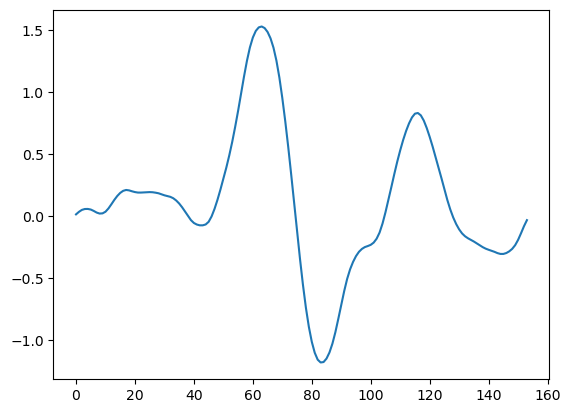

In [7]:
plt.plot(result['beta'])

In [15]:
def bothphase(b, X1, X2):
    nu1 = X1@b # response to target
    nu2 = X2@b # response to distractor
    #return 1/(1+np.exp(-np.abs(nu1-nu2)))
    p1 = np.exp(nu1)+np.exp(-nu1)
    p2 = np.exp(nu2)+np.exp(-nu2)
    return p1/(p1+p2)

binF = Binomial(bothphase)

t=perf_counter()
result2 = maximize(lambda b: binF(b, y, data['pedestal_test'], data['pedestal'])-150*smooth(b), 
                  np.random.rand(154), fconv=0e-5, maxiters=100, report=1)
print('elapsed', perf_counter()-t)

Newton's method
Iteration    1 fval -1146.61 grad 6.223171e+01 : newton step
Iteration    2 fval -983.724 grad 2.655712e-01 : newton step
Iteration    3 fval -972.373 grad 8.160143e-02 : newton step
Iteration    4 fval -972.045 grad 1.227359e-02 : newton step
Iteration    5 fval -972.035 grad 2.025876e-03 : newton step
Iteration    6 fval -972.035 grad 3.951504e-04 : newton step
Iteration    7 fval -972.035 grad 9.576216e-05 : newton step
Iteration    8 fval -972.035 grad 2.253490e-05 : newton step
Iteration    9 fval -972.035 grad 5.922738e-06 : newton step
Iteration   10 fval -972.035 grad 1.599735e-06 : newton step
Iteration   11 fval -972.035 grad 4.550616e-07 : newton step
Iteration   12 fval -972.035 grad 1.320502e-07 : newton step
Iteration   13 fval -972.035 grad 3.902858e-08 : newton step
Iteration   14 fval -972.035 grad 1.162971e-08 : newton step
Iteration   15 fval -972.035 grad 3.485280e-09
Gradient convergence in iteration 15, final value -972.03496798279
elapsed 0.748532

In [19]:
cProfile.run("maximize(lambda b: binF(b, y, data['pedestal_test'], data['pedestal'])-150*smooth(b), np.random.rand(154), fconv=0e-5, maxiters=100, report=1)")

Newton's method
Iteration    1 fval -1216.43 grad 5.070798e+01 : newton step
Iteration    2 fval -990.108 grad 1.921932e-01 : newton step
Iteration    3 fval -972.864 grad 8.685735e-02 : newton step
Iteration    4 fval -972.065 grad 1.958812e-02 : newton step
Iteration    5 fval -972.037 grad 3.235674e-03 : newton step
Iteration    6 fval -972.035 grad 6.998539e-04 : newton step
Iteration    7 fval -972.035 grad 1.682729e-04 : newton step
Iteration    8 fval -972.035 grad 4.131649e-05 : newton step
Iteration    9 fval -972.035 grad 1.057180e-05 : newton step
Iteration   10 fval -972.035 grad 2.826083e-06 : newton step
Iteration   11 fval -972.035 grad 7.806034e-07 : newton step
Iteration   12 fval -972.035 grad 2.224938e-07 : newton step
Iteration   13 fval -972.035 grad 6.467597e-08 : newton step
Iteration   14 fval -972.035 grad 1.908633e-08 : newton step
Iteration   15 fval -972.035 grad 5.682215e-09
Gradient convergence in iteration 15, final value -972.0349679827901
         65174

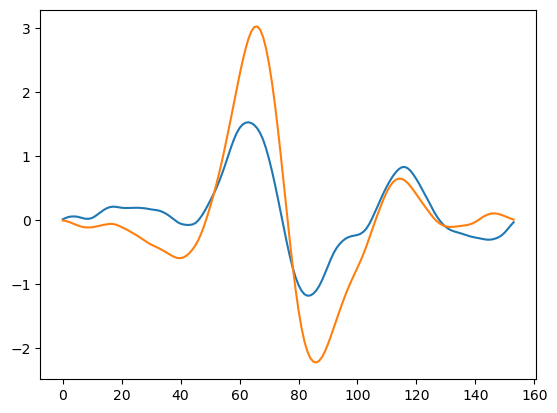

In [9]:
plt.plot(result['beta'])
s = np.sign(np.dot(result['beta'], result2['beta']))
plt.plot(s*result2['beta'])

In [10]:
from fitany.autodiff.tracing import tensorcorrelate, tensorconvolve

In [11]:
sz = 60
conv1 = tensorconvolve(data['pedestal_test'], np.random.rand(sz), mode='full', returntype='callable')
conv2 = tensorconvolve(data['pedestal'], np.random.rand(sz), mode='full', returntype='callable')

def bothphase(b, X1, X2):
    nu1 = conv1(b) # response to target
    nu2 = conv2(b) # response to distractor
    p1 = np.sum(np.exp(nu1)+np.exp(-nu1), axis=1)
    p2 = np.sum(np.exp(nu2)+np.exp(-nu2), axis=1)
    return p1/(p1+p2)

binF2 = Binomial(bothphase)
#binF(np.random.rand(sz), y, data['pedestal_test'], data['pedestal'])

In [16]:
t=perf_counter()
result3 = maximize(lambda b: binF2(b, y, data['pedestal_test'], data['pedestal'])-150*smooth(b), 
                  np.random.rand(sz), fconv=1e-5, maxiters=100, report=1)
print('elapsed', perf_counter()-t)

Newton's method
Iteration    1 fval -1134.71 grad 8.704391e+01 : newton step
Iteration    2 fval  -1026.6 grad 2.824921e-01 : newton step
Iteration    3 fval -1021.27 grad 1.977182e-02 : newton step
Iteration    4 fval -1017.47 grad 3.215871e-02 : newton step
Iteration    5 fval -1015.75 grad 2.121550e-02 : newton step
Iteration    6 fval -1015.08 grad 1.134204e-02 : newton step
Iteration    7 fval -1014.85 grad 6.888567e-03 : newton step
Iteration    8 fval -1014.78 grad 2.919084e-03 : newton step
Iteration    9 fval -1014.75 grad 1.516037e-03 : newton step
Iteration   10 fval -1014.75 grad 8.292752e-04 : newton step
Function convergence in iteration 10, final value -1014.7477488507348
elapsed 15.4395801


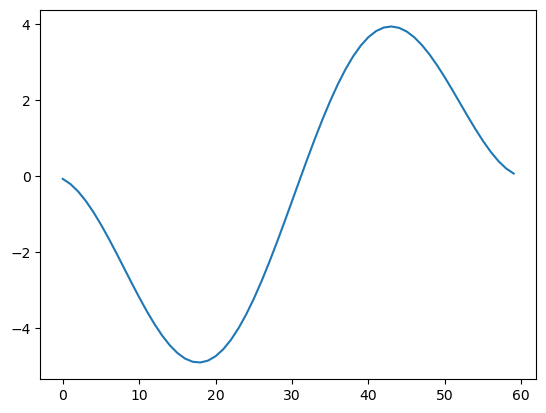

In [13]:
plt.plot(result3['beta'])